# RNN (LSTM)

In [1]:
# Importing necessary libraries
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from sklearn.preprocessing import MinMaxScaler
plt.style.use("ggplot")

from keras.models import Sequential
from keras.layers import LSTM, Dense, Dropout
from tensorflow.keras import layers

import tools.helper_functions as hf

In [2]:
# Loading data set
df = pd.read_excel('data/eth_api_data.xlsx')

In [3]:
df.set_index('t', inplace=True)

In [4]:
df = df[['price_usd_close']]

In [5]:
df

,price_usd_close
t,
2015-08-08,0.769981
2015-08-09,0.719830
2015-08-10,0.700705
2015-08-11,1.088361
2015-08-12,1.214071
...,...
2021-09-07,3423.552440
2021-09-08,3490.893336
2021-09-09,3428.141046


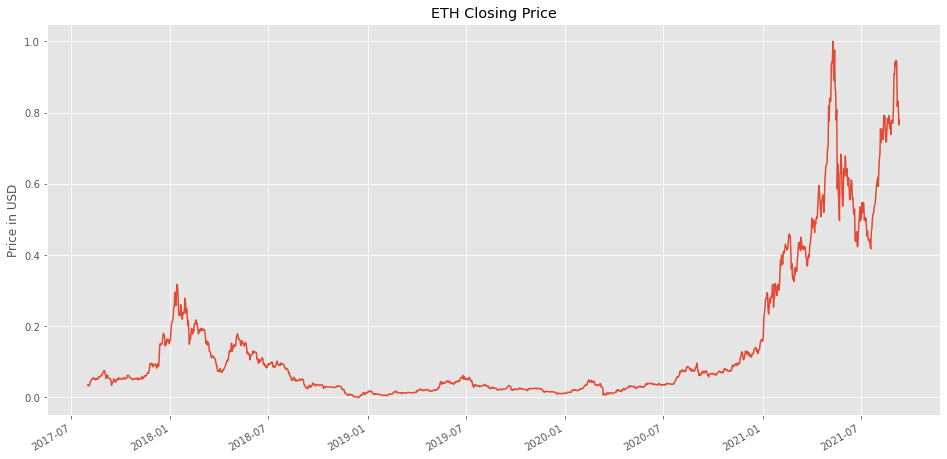

In [32]:
# Looking at historical closing price
df['price_usd_close'].plot(figsize=(16,8), title='ETH Closing Price', ylabel='Price in USD', xlabel='');

In [8]:
# Removing data points so that the data only reflects current market volatility from August 2017 onwards
df = df['2017-08-01':]

In [9]:
df

,price_usd_close
t,
2017-08-01,225.752000
2017-08-02,217.696000
2017-08-03,224.038000
2017-08-04,219.094000
2017-08-05,253.460000
...,...
2021-09-07,3423.552440
2021-09-08,3490.893336
2021-09-09,3428.141046


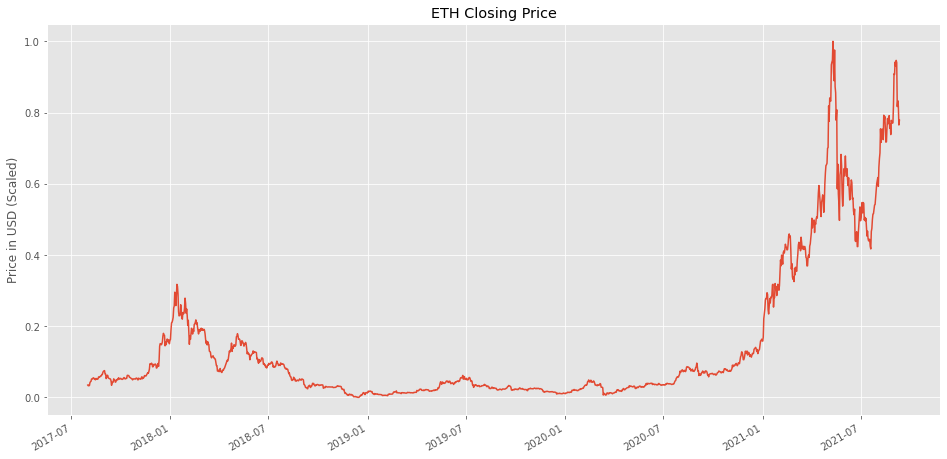

In [35]:
# Looking at closing price since August 2017
df['price_usd_close'].plot(figsize=(16,8), title='ETH Closing Price', ylabel='Price in USD (Scaled)', xlabel='');

In [11]:
# Normalizing/Scaling the Data
scaler = MinMaxScaler()
df = pd.DataFrame(scaler.fit_transform(df), columns=df.columns, index=df.index)

In [13]:
# How many periods looking back to learn
n_per_in  = 120

# How many periods to predict
n_per_out = 30

# Features (in this case it's 1 because there is only one feature: price)
n_features = 1

# Splitting the data into appropriate sequences
X, y = hf.split_sequence(list(df.price_usd_close), n_per_in, n_per_out)

# Reshaping the X variable from 2D to 3D
X = X.reshape((X.shape[0], X.shape[1], n_features))

In [14]:
def layer_maker(n_layers, n_nodes, activation, drop=None, d_rate=.5):
    """
    Creates a specified number of hidden layers for an RNN
    Optional: Adds regularization option - the dropout layer to prevent potential overfitting (if necessary)
    """
    
    # Creating the specified number of hidden layers with the specified number of nodes
    for x in range(1,n_layers+1):
        model.add(LSTM(n_nodes, activation=activation, return_sequences=True))

        # Adds a Dropout layer after every Nth hidden layer (the 'drop' variable)
        try:
            if x % drop == 0:
                model.add(Dropout(d_rate))
        except:
            pass

In [15]:
# Instatiating the model
model = Sequential()

# Activation
activ = "softsign"

# Input layer
model.add(LSTM(30, activation=activ, return_sequences=True, input_shape=(n_per_in, n_features)))

# Hidden layers
layer_maker(n_layers=6, n_nodes=12, activation=activ)

# Final Hidden layer
model.add(LSTM(10, activation=activ))

# Output layer
model.add(Dense(n_per_out))

# Model summary
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm (LSTM)                  (None, 120, 30)           3840      
_________________________________________________________________
lstm_1 (LSTM)                (None, 120, 12)           2064      
_________________________________________________________________
lstm_2 (LSTM)                (None, 120, 12)           1200      
_________________________________________________________________
lstm_3 (LSTM)                (None, 120, 12)           1200      
_________________________________________________________________
lstm_4 (LSTM)                (None, 120, 12)           1200      
_________________________________________________________________
lstm_5 (LSTM)                (None, 120, 12)           1200      
_________________________________________________________________
lstm_6 (LSTM)                (None, 120, 12)           1

In [22]:
# Compiling the data with selected specifications
model.compile(optimizer='adam', loss='mse', metrics=['accuracy'])

In [17]:
res = model.fit(X, y, epochs=5, batch_size=32, validation_split=0.1)

Epoch 1/5
38/38 [==============================] - 12s 303ms/step - loss: 0.0148 - accuracy: 0.0329 - val_loss: 0.3165 - val_accuracy: 0.0296
Epoch 2/5
38/38 [==============================] - 10s 263ms/step - loss: 0.0083 - accuracy: 0.0428 - val_loss: 0.1964 - val_accuracy: 0.0296
Epoch 3/5
38/38 [==============================] - 10s 261ms/step - loss: 0.0054 - accuracy: 0.0387 - val_loss: 0.1281 - val_accuracy: 0.0667
Epoch 4/5
38/38 [==============================] - 10s 253ms/step - loss: 0.0035 - accuracy: 0.0313 - val_loss: 0.1045 - val_accuracy: 0.0667
Epoch 5/5
38/38 [==============================] - 10s 260ms/step - loss: 0.0029 - accuracy: 0.0296 - val_loss: 0.0645 - val_accuracy: 0.0667


In [24]:
def visualize_training_results(results):
    """
    Plots the loss and accuracy for the training and testing data
    """
    history = results.history
    plt.figure(figsize=(12,4))
    plt.plot(history['val_loss'])
    plt.plot(history['loss'])
    plt.legend(['val_loss', 'loss'])
    plt.title('Loss')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.show()
    
    plt.figure(figsize=(12,4))
    plt.plot(history['val_accuracy'])
    plt.plot(history['accuracy'])
    plt.legend(['val_accuracy', 'accuracy'])
    plt.title('Accuracy')
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy')
    plt.show()

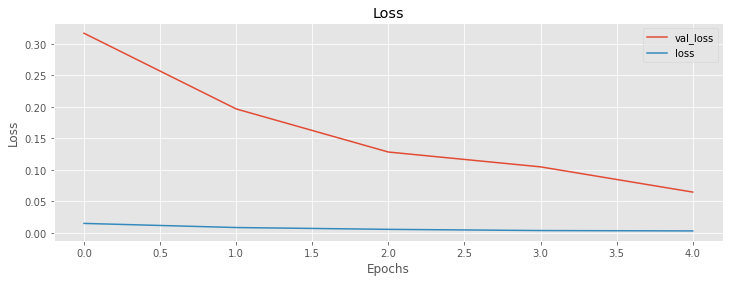

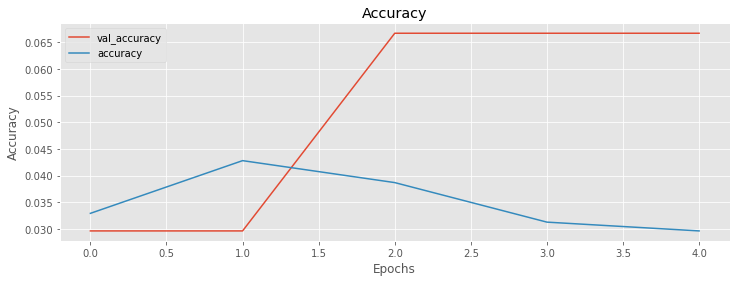

In [26]:
visualize_training_results(res)

Predicted Prices:
 [[1749.7028680652613], [1665.5392799982326], [1573.6663032677416], [1634.291228909829], [1770.7061758418702], [1674.328217017338], [1820.9569585837096], [1775.55463951769], [1666.4192459377875], [1462.80789690035], [1691.8111736549793], [1762.2721738521088], [1801.580405896965], [1752.2133662954734], [1793.9633758851483], [1811.913121433678], [1807.5745798648973], [1868.2677388116304], [1884.2990318929355], [1866.5486250701208], [1826.0885904738088], [1892.0799436810887], [1872.3039824717935], [1842.0070549120753], [1814.3525839199463], [1856.5244215465557], [1788.6191241439658], [1799.9816752000804], [1929.8195407902165], [1787.3649716355417]]

Actual Prices:
 [[3324.172743915513], [3265.44335713513], [3309.15313607015], [3156.509427280665], [3014.846038920412], [3020.089920029215], [3182.702225387158], [3286.935326056703], [3226.083936944288], [3242.115556586883], [3319.257273767981], [3174.497105973165], [3223.941655611519], [3102.062905653585], [3265.590215779964

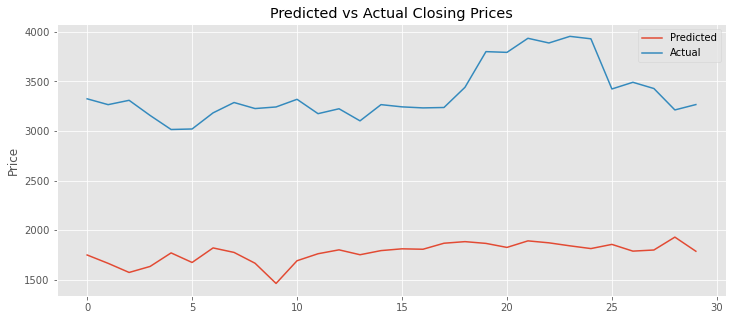

In [27]:
plt.figure(figsize=(12,5))

# Getting predictions by predicting from the last available X variable
yhat = model.predict(X[-1].reshape(1, n_per_in, n_features)).tolist()[0]

# Transforming values back to their normal prices
yhat = scaler.inverse_transform(np.array(yhat).reshape(-1,1)).tolist()

# Getting the actual values from the last available y variable which correspond to its respective X variable
actual = scaler.inverse_transform(y[-1].reshape(-1,1))

# Printing and plotting those predictions
print("Predicted Prices:\n", yhat)
plt.plot(yhat, label='Predicted')

# Printing and plotting the actual values
print("\nActual Prices:\n", actual.tolist())
plt.plot(actual.tolist(), label='Actual')

plt.title(f"Predicted vs Actual Closing Prices")
plt.ylabel("Price")
plt.legend()
plt.savefig("BTC_validation.png")
plt.show();

            price_usd_close
2021-09-11      2013.162745
2021-09-12      1903.048447
2021-09-13      1761.327386
2021-09-14      1822.059779
2021-09-15      2041.037390
2021-09-16      1896.285308
2021-09-17      2101.984597
2021-09-18      2001.990638
2021-09-19      1879.215407
2021-09-20      1621.760548
2021-09-21      1908.794057
2021-09-22      2003.929926
2021-09-23      2044.846758
2021-09-24      1966.343488
2021-09-25      2064.746392
2021-09-26      2053.075939
2021-09-27      2052.939594
2021-09-28      2141.798243
2021-09-29      2157.267220
2021-09-30      2149.492035
2021-10-01      2081.887451
2021-10-02      2152.630767
2021-10-03      2125.805696
2021-10-04      2078.411574
2021-10-05      2034.545113
2021-10-06      2095.526436
2021-10-07      2006.511095
2021-10-08      2053.389081
2021-10-09      2196.680970
2021-10-10      2026.980842


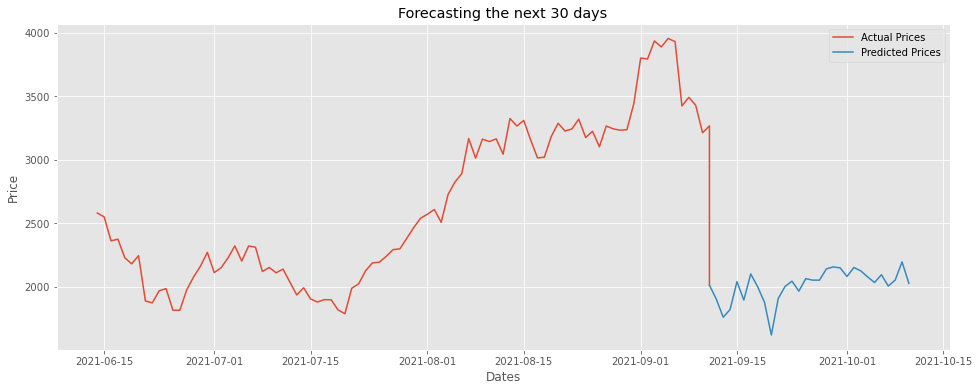

In [29]:
# Predicting off of y because it contains the most recent dates
yhat = model.predict(np.array(df.tail(n_per_in)).reshape(1, n_per_in, n_features)).tolist()[0]

# Transforming the predicted values back to their original prices
yhat = scaler.inverse_transform(np.array(yhat).reshape(-1,1)).tolist()

# Creating a DF of the predicted prices
preds = pd.DataFrame(yhat, index=pd.date_range(start=df.index[-1], periods=len(yhat), freq="D"), columns=df.columns)

# Printing the predicted prices
print(preds)

# Number of periods back to visualize the actual values
pers = 90

# Transforming the actual values to their original price
actual = pd.DataFrame(scaler.inverse_transform(df[["price_usd_close"]].tail(pers)), index=df.price_usd_close.tail(pers).index, columns=df.columns).append(preds.head(1))

# Plotting
plt.figure(figsize=(16,6))
plt.plot(actual, label="Actual Prices")
plt.plot(preds, label="Predicted Prices")
plt.ylabel("Price")
plt.xlabel("Dates")
plt.title(f"Forecasting the next {len(yhat)} days")
plt.legend()
plt.savefig("BTC_predictions.png")
plt.show()